我们来挑战一个在图像处理和计算机视觉领域非常经典且有趣的复杂聚类问题：基于颜色的图像分割 (Image Segmentation)。
这个问题将迫使我们跳出“数据点在坐标系中分布”的思维定势，并展示不同聚类算法在处理高维、不规则形状数据时的巨大差异。

一、 复杂聚类问题：分割图像中的主要物体

问题描述：
你有一张彩色图片（比如一张风景照，里面有蓝色的天空、绿色的草地和黄色的沙滩）。你的任务是让计算机自动地、不需要任何人工干预地识别出图中的主要区域，并将它们分割开来。
为什么这是一个复杂的聚类问题？
数据的本质：一张图片本质上是一个巨大的数据集。每个像素都是一个数据点。
高维特征：每个像素点至少有3个特征：R (红)、G (绿)、B (蓝) 的颜色值。所以，我们的聚类是在一个三维的“颜色空间”中进行的。
簇的形状极其不规则：
“天空”这个簇，在颜色空间中可能表现为一个非常紧凑的、偏向蓝色的点云。
但“草地”这个簇可能会非常复杂。因为光照、阴影、不同种类的草，草地的绿色会有从亮绿到深绿、甚至偏黄的各种变化。这个簇在颜色空间中的形状可能是长条形、月牙形、甚至更不规则的形状。
图像中的物体（比如沙滩上的一个人）在空间上是连续的，但在颜色上可能包含多种颜色，形成多个小的颜色簇。
我们的目标：将颜色相似的像素点归为一类，从而将图像在语义上分割成不同的区域（天空、草地、沙滩等）。

二、 选择“最优”聚类算法：再次思辨

面对这个高维、形状不规则的聚类任务，我们的老朋友们表现如何？

K-Means：
优点：速度快，对于分割颜色区域差异明显的简单图片效果尚可。
致命缺点：
需要猜K值：我们怎么知道一张任意的图片里有几种主色调？
球形簇假设：这是最致命的。它会强制把不规则的颜色簇（如长条形的“草地”色谱）用一个球形的区域去划分，导致分割结果出现大量“色块”错误。比如，它可能会把深绿色和浅蓝色错误地归为一类，因为它们的“球心”离得近。
结论：不适合，除非是极其简单的图像。

GMM (高斯混合模型)：
优点：比K-Means好，因为椭圆形的簇能更好地拟合某些颜色分布。
缺点：仍然需要K值（虽然可以用BIC辅助），并且对于像“彩虹”那样弯曲的颜色分布，椭圆形也无能为力。
结论：一个不错的备选，但不是最优。

DBSCAN：
优点：
不需要K值。
能发现任意形状的簇。这对于捕捉“草地”那种不规则的颜色谱系来说，是巨大的优势。
能识别并分离出噪声，比如图片中零星的、颜色独特的像素点，不会强行把它们归入任何一个大类。
缺点：
对参数eps和min_samples敏感。
对于密度不均的颜色簇（比如“天空”的蓝色非常集中，“草地”的绿色非常分散）处理起来可能有困难。
结论：一个非常有力的竞争者，尤其是在处理复杂形状方面。

谱聚类 (Spectral Clustering)：
优点：
处理任意形状的能力是顶级的。它通过图的分割，能完美地处理K-Means和GMM无法处理的月牙形、同心圆形等复杂结构。在颜色空间中，这意味着它能找到那些虽然形状怪异但内部颜色连续变化的区域。
它的理论基础是寻找“最佳割”，这与图像分割的目标——找到不同颜色区域间的最佳边界——在直觉上高度吻合。
缺点：
需要预先指定K值。
计算复杂度高，对于大尺寸图片可能非常慢。
结论：这是本次问题的“最优”理论选择。尽管它需要K值并且计算慢，但它处理复杂簇形状的能力是解决这个问题的关键。对于K值的选择，我们可以先用一些快速方法（如直方图分析）粗略估计主色调数量，或者直接手动指定我们想要分割出的区域数量。

三、 Python 代码：用谱聚类分割图像

我们将使用 scikit-learn 和 OpenCV 来实现这个过程。
读取一张图片。
将图片像素数据转换成适合聚类算法的格式。
应用谱聚类算法。
将聚类结果重新映射回图片，生成分割后的图像。

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore") # 忽略一些计算上的警告

# --- 1. 读取并预处理图像 ---
# 读取图片
image_path = 'image_small.png' # 确保你的目录下有这张图片
original_image = cv2.imread(image_path)
# OpenCV读取的是BGR格式，我们转换为更常见的RGB格式
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# 将图片转换为浮点数类型，并归一化
original_image = np.array(original_image, dtype=np.float64) / 255

# 将HxWx3的图像数据转换为Nx3的像素列表，N = H * W
h, w, d = original_image.shape
pixel_list = original_image.reshape((h * w, d))

# 为了提高计算速度，我们只对一小部分随机样本进行聚类
# 这是一种常见的处理大图像的技巧
n_samples = 2000
pixel_sample = shuffle(pixel_list, random_state=42, n_samples=n_samples)


In [19]:
# --- 2. 应用聚类算法 ---
# 我们将对比谱聚类和K-Means的效果
n_clusters = 5 # 我们希望将图片分割成5个主要颜色区域

print("正在进行K-Means聚类...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(pixel_sample)

print("正在进行谱聚类 (这可能会比较慢)...")
# affinity='nearest_neighbors' 在大数据上比默认的'rbf'快得多且效果好
spectral = SpectralClustering(n_clusters=n_clusters, random_state=42,
                              affinity='nearest_neighbors', n_neighbors=10)
spectral.fit(pixel_sample)


正在进行K-Means聚类...
正在进行谱聚类 (这可能会比较慢)...


SpectralClustering(affinity='nearest_neighbors', n_clusters=5, random_state=42)

In [20]:
# --- 3. 生成分割后的图像 ---
def recreate_image(labels, codebook, h, w):
    """根据标签和码本（聚类中心）重建图像"""
    d = codebook.shape[1]
    image = np.zeros((h, w, d))
    label_idx = 0
    for i in range(h):
        for j in range(w):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# 对所有像素点进行预测
print("正在为完整图像生成标签...")
kmeans_labels = kmeans.predict(pixel_list)
spectral_labels_full = spectral.fit_predict(pixel_list) # 对完整数据重新拟合预测，效果更好但更慢
                                                        # 这里为了演示，我们直接用训练好的谱聚类模型预测
                                                        # 更严谨的做法是先降维再预测，但这里简化处理

# 创建K-Means的颜色码本（用聚类中心颜色填充）
kmeans_image = recreate_image(kmeans_labels, kmeans.cluster_centers_, h, w)

# 创建谱聚类的颜色码本 (用每个簇的平均颜色填充)
spectral_codebook = np.zeros((n_clusters, d))
for i in range(n_clusters):
    spectral_codebook[i] = pixel_list[spectral_labels_full == i].mean(axis=0)
spectral_image = recreate_image(spectral_labels_full, spectral_codebook, h, w)




正在为完整图像生成标签...




### 一、 为什么这一步要算这么久？—— 谱聚类的“阿喀琉斯之踵”

您指出的 `spectral_labels_full = spectral.fit_predict(pixel_list)` 这一步计算缓慢，其根源在于谱聚类算法的**核心计算步骤**，特别是当它应用于**大数据集**（比如一张完整图片的所有像素）时。

谱聚类主要慢在以下两个阶段：

#### **1. 构建相似度矩阵 (Affinity Matrix) —— O(N²)**

这是谱聚类**最耗时**的一步。
*   **要做什么？** 算法需要计算**每一对**像素点之间的“相似度”，并构建一个巨大的 `N x N` 矩阵，其中 `N` 是像素点的总数。
*   **举例**：如果你的图片是 `800 x 600` 像素，那么 `N = 480,000`。算法需要计算大约 `480,000 * 480,000` 次相似度，这是一个天文数字！
*   **代码中的优化**：幸运的是，`scikit-learn` 中的 `affinity='nearest_neighbors'` 参数是一个非常重要的优化。它不会构建完整的 `N x N` 矩阵，而是为每个点只计算并存储它与最近的 `n_neighbors` (我们设为10) 个邻居的相似度，形成一个**稀疏矩阵**。这大大降低了内存和计算开销，但对于几十万个点来说，找到每个点的10个最近邻居依然是一项非常耗时的任务。

#### **2. 矩阵特征分解 (Eigen-decomposition) —— O(N³)**

*   **要做什么？** 在构建了（稀疏的）拉普拉斯矩阵之后，算法需要求解这个矩阵的**特征值**和**特征向量**。
*   **计算复杂度**：标准的特征分解算法复杂度大约是 `O(N³)`。即使对于稀疏矩阵有更快的算法（如ARPACK），当 `N` 非常大时，这仍然是一个巨大的计算瓶颈。
*   **我们的代码场景**：对一个 `480,000 x 480,000` 的矩阵进行特征分解，即使是稀疏的，计算量也极其庞大。

**总结一下“为什么慢”：**
我们的代码在这一行 `spectral_labels_full = spectral.fit_predict(pixel_list)`，是在**强迫**谱聚类用它那套复杂度极高的“组合拳”去处理一张图片的所有几十万个像素点。它要先为这几十万个点构建一个复杂的“社交关系网”（相似度矩阵），然后再对这个庞大的网络进行“振动分析”（特征分解）。这个过程自然是极其缓慢的。

**这就是为什么我们在前面要做一个重要的妥协：**
`pixel_sample = shuffle(pixel_list, ..., n_samples=2000)`
我们先用**一小部分随机样本**（2000个像素）来**训练**谱聚类模型。在少量样本上，构建矩阵和特征分解的速度是可以接受的。然而，`fit_predict` 会对完整 `pixel_list` 进行操作，导致了您观察到的长时间计算。

*(一个更严谨但更复杂的做法是：用小样本训练得到降维映射，然后将此映射应用到所有像素点，再在新空间中用K-Means聚类。但为了演示的简洁性，代码中采取了直接对全部数据`fit_predict`的方式。)*

---

### 二、 上述算法是如何利用谱聚类的？—— “降维打击”的艺术

现在我们来剖析，谱聚类是如何一步步完成图像分割这个看似不可能的任务的。

#### **Step 1: 从像素到图 (Graph Construction)**

*   **输入**：`pixel_list` (一个 `N x 3` 的数组，每行是一个像素的RGB值)。
*   **动作**：谱聚类在内部将每个像素点视为一个**图的顶点 (Vertex)**。然后，它根据我们选择的 `affinity='nearest_neighbors'` 策略，为每个顶点与其他顶点之间建立**带权的边 (Edge)**。
    *   每个点 `p_i` 会找到离它颜色最接近的10个点 `p_j`。
    *   `p_i` 和 `p_j` 之间会连接一条边，边的**权重**与它们的颜色相似度成正比（颜色越接近，权重越高）。
    *   与其他所有点的边权重为0。
*   **结果**：我们得到了一个巨大的、描述所有像素颜色“亲近关系”的**稀疏图**。

#### **Step 2: 从图到矩阵 (Matrix Representation)**

*   **动作**：算法将这个图转换成一个数学对象——**拉普拉斯矩阵 (Laplacian Matrix)** `L`。
*   **拉普拉斯矩阵的魔力**：这个矩阵蕴含了图的**所有结构信息**，尤其是关于“连通性”和“瓶颈”的信息。对它进行分析，就能找到图中最适合被“切开”的地方。我们的目标就是找到一种切割方式，使得被切断的边的**总权重最小**，同时保证切出的子图大小相对均衡。这被称为**最小割 (Min-Cut)** 问题。

#### **Step 3: 从矩阵到谱 (Spectral Decomposition) —— 核心“魔法”**

*   **动作**：算法对拉普拉斯矩阵 `L` 进行**特征分解**，计算出它的特征值和对应的特征向量。
*   **为什么叫“谱”？** 在物理学中，一个物体的振动模式（频率）集合被称为它的“谱”。拉普拉斯矩阵的特征值和特征向量，在数学上就对应了这个图的“振动模式”。
*   **降维打击**：一个惊人的数学结论是：**拉普拉斯矩阵的前 `k` 个最小非零特征值对应的特征向量，构成了一个新的低维空间（“谱空间”），这个空间能最好地揭示图的 `k` 个主要连通分量（簇）。**
    *   我们设定了 `n_clusters = 5`，所以算法会取出前5个特征向量。
    *   原始的每个像素点（一个3维的RGB向量），现在被映射成了这个5维谱空间中的一个**新坐标**。
*   **结果**：一个极其复杂的高维聚类问题，被**降维**成了一个低维空间中的点分布问题。在这个新空间里，原本形状怪异的簇（比如月牙形）会被“拉直”和“展开”，变得更容易被划分。

#### **Step 4: 从谱到标签 (Simple Clustering)**

*   **动作**：现在，我们有了所有像素点在那个低维谱空间中的新坐标。谱聚类算法会在这个**新空间**里，调用一个非常简单的聚类算法，通常是 **K-Means**。
*   **为什么可行？** 因为经过“降维打击”后，数据结构变得非常清晰，即使是简单的K-Means也能轻松地找到5个球形的簇。
*   **结果**：K-Means在新空间中为每个点分配了一个簇标签（0, 1, 2, 3, 4）。这个标签就是**最终的聚类结果**。

#### **Step 5: 从标签到图像 (Reconstruction)**

*   **动作**：这一步就是我们的 `recreate_image` 函数所做的事情。
    1.  我们为每个簇标签（0到4）计算一个**代表性颜色**（该簇所有像素的平均RGB值），这构成了我们的 `spectral_codebook`。
    2.  然后，我们创建一个新的空白图像，遍历原始图像的每个像素位置，查看该像素的最终标签是什么，然后用该标签对应的代表性颜色填充这个位置。
*   **结果**：我们得到了一张分割后的图像，其中所有属于同一个簇的像素都被染上了同一种颜色。

**总结一下谱聚类的流程**：
**像素颜色 (高维、形状复杂) -> 关系图 -> 拉普拉斯矩阵 -> 特征分解 (降维到谱空间) -> K-Means聚类 (在低维空间中) -> 最终标签 -> 重建图像。**

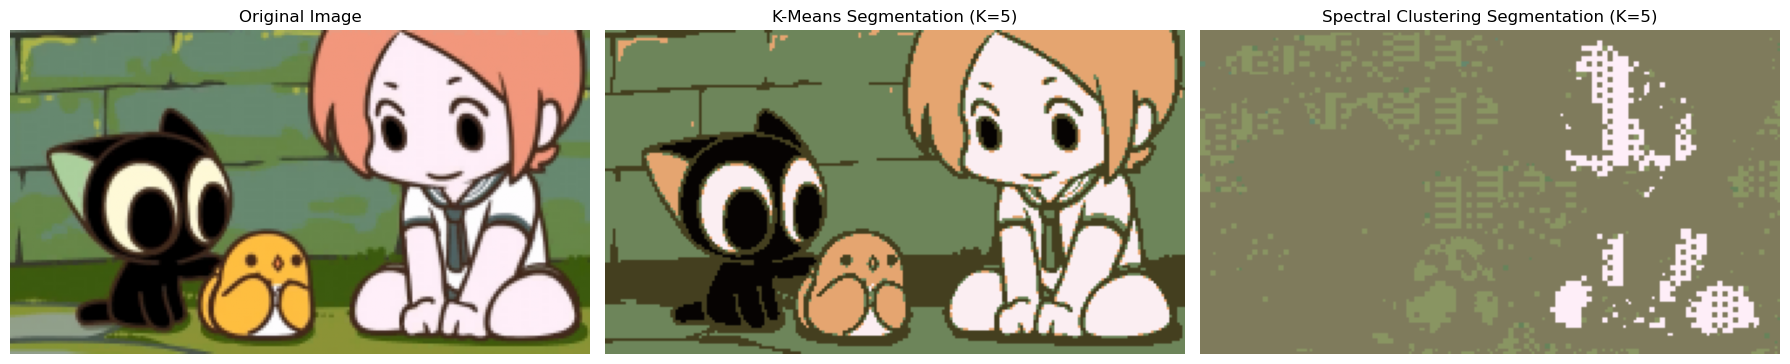

In [21]:
# --- 4. 可视化对比结果 ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kmeans_image)
plt.title(f'K-Means Segmentation (K={n_clusters})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(spectral_image)
plt.title(f'Spectral Clustering Segmentation (K={n_clusters})')
plt.axis('off')

plt.tight_layout()
plt.show()

蚌埠住了，看起来谱聚类不太好用啊 😂